# Introduction to Fugue


<img src="img/fugue_architecture.png" align="center" width="800"/>

## PyCaret

[PyCaret](https://github.com/pycaret/pycaret) is a low code machine learning framework that automates a lot of parts of the machine learning pipeline. With just a few lines of code, several models can be trained on a dataset. In this post, we explore how to scale this capability by running several PyCaret training jobs in a distributed manner on Spark or Dask.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

In [3]:
from pycaret.datasets import get_data
df = get_data('titanic')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
from pycaret.classification import *
clf = setup(data = df, target = 'Survived', session_id=123, silent = True, verbose=False, html=False)
models = compare_models(fold = 3, sort = "Accuracy", turbo = True, verbose=False)
results = pull().reset_index(drop=True)
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Ada Boost Classifier,0.8154,0.8523,0.7215,0.7901,0.7536,0.6066,0.6088,0.0900
1,Decision Tree Classifier,0.8122,0.7988,0.7375,0.7739,0.7539,0.6024,0.6041,0.5567
2,Ridge Classifier,0.8122,0.0000,0.7296,0.7774,0.7527,0.6016,0.6024,0.5467
3,Gradient Boosting Classifier,0.8090,0.8551,0.6802,0.8039,0.7361,0.5881,0.5938,0.1167
4,Logistic Regression,0.8074,0.8578,0.7215,0.7717,0.7455,0.5909,0.5920,1.8767
5,Random Forest Classifier,0.7978,0.8444,0.6640,0.7889,0.7202,0.5637,0.5695,0.1300
6,Light Gradient Boosting Machine,0.7945,0.8535,0.6885,0.7651,0.7242,0.5612,0.5637,0.2000
7,Extra Trees Classifier,0.7898,0.8470,0.6598,0.7707,0.7100,0.5469,0.5516,0.1367
8,SVM - Linear Kernel,0.7110,0.0000,0.5530,0.6604,0.5912,0.3739,0.3830,0.0267
9,K Neighbors Classifier,0.7062,0.7331,0.5818,0.6402,0.6071,0.3738,0.3767,0.6433


## Wrapping Logic in Function

In [5]:
def wrapper(df: pd.DataFrame) -> pd.DataFrame:
    clf = setup(data = df, 
                target = 'Survived', 
                session_id=123, 
                silent = True, 
                verbose=False, 
                html=False)
    models = compare_models(fold = 3,  
                            sort = "Accuracy", 
                            turbo = True, 
                            verbose=False)
    results = pull().reset_index(drop=True)

    return pd.DataFrame(dict(sex=df.iloc[0]["Sex"],
                             model=results["Model"], 
                             auc=results["AUC"], 
                             recall=results["Recall"],
                             precision=results["Prec."],
                             time=results["TT (Sec)"]))

## Fugue Transform

In [6]:
from fugue import transform

schema = """model:str, auc:float, recall:float, precision:float, time:float"""

res = transform(df, wrapper, schema=schema)
res[0:5]

,model,auc,recall,precision,time
0,Ada Boost Classifier,0.8523,0.7215,0.7901,0.1033
1,Decision Tree Classifier,0.7988,0.7375,0.7739,0.0500
2,Ridge Classifier,0.0000,0.7296,0.7774,0.0533
3,Gradient Boosting Classifier,0.8551,0.6802,0.8039,0.1200
4,Logistic Regression,0.8578,0.7215,0.7717,0.1367


## Partition Male and Female

In [7]:
schema = """sex:str, model:str, auc:float, recall:float, precision:float, time:float"""

res = transform(df, wrapper, schema=schema, partition={"by":"Sex"})
res.sort_values("auc")[0:5]

,sex,model,auc,recall,precision,time
0,female,Ridge Classifier,0.0000,0.8970,0.8972,0.0100
19,male,SVM - Linear Kernel,0.0000,0.0123,0.1667,0.0133
14,male,Ridge Classifier,0.0000,0.1368,0.5515,0.0100
13,female,SVM - Linear Kernel,0.0000,0.2242,0.8821,0.0100
26,male,Quadratic Discriminant Analysis,0.4636,0.3666,0.1648,0.0133


## Bringing to Spark

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

22/08/17 03:03:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/17 03:03:21 WARN MetricsSystem: Using default name SparkStatusTracker for source because neither spark.metrics.namespace nor spark.app.id is set.


In [10]:
res = transform(df.replace({np.nan: None}), 
                wrapper, 
                schema=schema, 
                partition={"by":"Sex"}, 
                engine=spark,
                save_path="/tmp/results.parquet")

View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi
View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


## FugueSQL

In [11]:
%%fsql spark
LOAD "/tmp/results.parquet"
PRINT

View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


,sex,model,auc,recall,precision,time
0,female,Extra Trees Classifier,0.8916,0.9330,0.8686,0.2800
1,female,Logistic Regression,0.8882,0.9088,0.8735,1.2767
2,female,Ridge Classifier,0.0000,0.8964,0.8760,0.0300
3,female,Random Forest Classifier,0.8846,0.9451,0.8456,0.3433
4,female,Decision Tree Classifier,0.7396,0.8963,0.8662,0.0267
5,female,Gradient Boosting Classifier,0.8893,0.8781,0.8727,0.1167
6,female,Light Gradient Boosting Machine,0.8742,0.8963,0.8559,0.0500
7,female,Ada Boost Classifier,0.8262,0.8842,0.8530,0.1333
8,female,Dummy Classifier,0.5000,1.0000,0.7489,0.0133
9,female,K Neighbors Classifier,0.6091,0.8660,0.7690,0.0367


In [12]:
%%fsql spark
df = LOAD "/tmp/results.parquet"

SELECT sex, AVG(time) AS time
  FROM df
 GROUP BY sex
 PRINT

View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi
View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


,sex,time
0,female,0.172857
1,male,0.122864


## Collecting to Local DataFrame

In [13]:
%%fsql spark
df = LOAD "/tmp/results.parquet"

TAKE 5 ROWS FROM df PREPARTITION BY sex PRESORT auc DESC
YIELD LOCAL DATAFRAME AS result

View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi
View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


In [14]:
result.native

,sex,model,auc,recall,precision,time
0,female,Extra Trees Classifier,0.8916,0.9330,0.8686,0.2800
1,female,Gradient Boosting Classifier,0.8893,0.8781,0.8727,0.1167
2,female,Logistic Regression,0.8882,0.9088,0.8735,1.2767
3,female,Random Forest Classifier,0.8846,0.9451,0.8456,0.3433
4,female,Light Gradient Boosting Machine,0.8742,0.8963,0.8559,0.0500
5,male,Logistic Regression,0.6630,0.1538,0.7238,0.3067
6,male,Gradient Boosting Classifier,0.6499,0.1026,0.6762,0.1767
7,male,Random Forest Classifier,0.6323,0.0513,0.4111,0.3700
8,male,Light Gradient Boosting Machine,0.6276,0.2051,0.4667,0.0600
9,male,Extra Trees Classifier,0.6189,0.0897,0.4259,0.3200


## Invoking Python Code

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
def plotter(df:pd.DataFrame) -> None:

    fig = plt.figure(figsize=(12,10))
    ax = sns.scatterplot(x=df["precision"],y=df["recall"],hue=df["sex"])
    # The magic starts here:
    for line in range(0,df.shape[0]):
         ax.text(df["precision"].iloc[line]+0.01, df["recall"].iloc[line], 
                 df["model"].iloc[line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')

    plt.title('Precision and Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

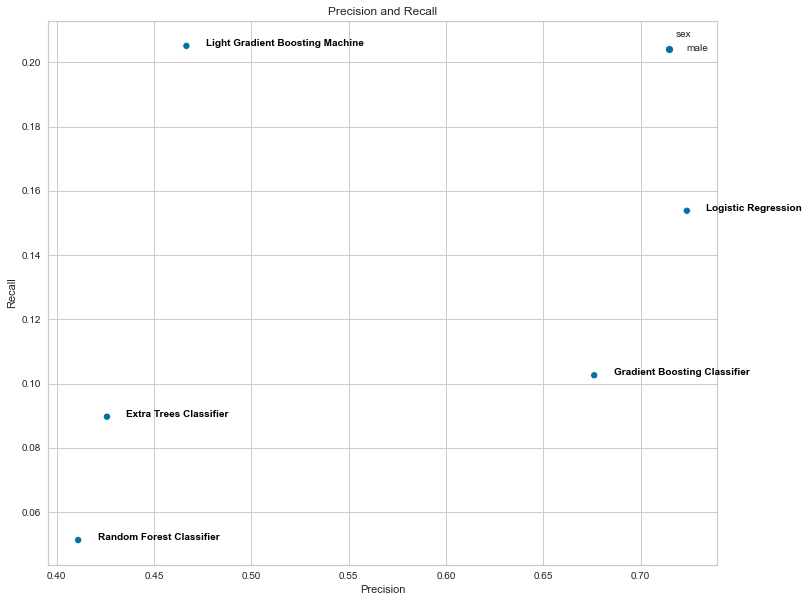

In [16]:
%%fsql
SELECT * 
  FROM result
 WHERE sex = 'male'

OUTPUT USING plotter